# Results

Objectives -- we want to understand "how close did our predictions come to the actual frequency of tokens?" and further, "Is this a reliable method for predicting / forecasting tokens over a 12-month period?"

Complications:
* Our forecasts are based on a normalized and rescaled moving average
  * So a 5% error (say) between a popular token and unpopular token do not necessarily carry the same weight, even if they were in the same cluster
* Our VAR forecasts are generated per cluster, so there's no interaction terms between tokens across clusters.
* Tokens are not grouped by topic but rather by similarity of time curves.
* It's not clear what should count more:
  * RMSE / MAE / etc. evaluated on a daily basis, between actual and predicted values
  * Sum of predicted values divided by sum of actual values -- then the daily fluctuations are less important than the total token frequency predicted over a year
  * Weighted vs unweighted by original token frequency (i.e. re-scaling values back to their original magnitude)
    * This will make some errors more impactful than others

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
da1 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df1.csv')
da2 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df2.csv')
da3 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df3.csv')
da4 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df4.csv')
da5 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df5.csv')
da6 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df6.csv')
da7 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df7.csv')
da8 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df8.csv')
da9 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df9.csv')
da10 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df10.csv')
da11 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df11.csv')
da12 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df12.csv')
da13 = pd.read_csv('../datasets/lemmatized_date_df/lemmatized_date_df13.csv')

ma1 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df1.csv')
ma2 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df2.csv')
ma3 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df3.csv')
ma4 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df4.csv')
ma5 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df5.csv')
ma6 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df6.csv')
ma7 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df7.csv')
ma8 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df8.csv')
ma9 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df9.csv')
ma10 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df10.csv')
ma11 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df11.csv')
ma12 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df12.csv')
ma13 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df13.csv')
ma14 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df14.csv')
ma15 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df15.csv')
ma16 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df16.csv')
ma17 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df17.csv')
ma18 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df18.csv')
ma19 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df19.csv')
ma20 = pd.read_csv('../datasets/moving_avg_df/moving_avg_df20.csv')

var1 = pd.read_csv('../datasets/VAR_forecast_results/VAR_forecast_results1.csv')
var2 = pd.read_csv('../datasets/VAR_forecast_results/VAR_forecast_results2.csv')
var3 = pd.read_csv('../datasets/VAR_forecast_results/VAR_forecast_results3.csv')

In [3]:
labels_df = pd.read_csv('../datasets/labels_df_no_numbers.csv')
labels_df['original_tokens'] = labels_df['original_tokens'].str.replace('.',' ')

results_df = pd.concat([var1, var2, var3], axis=1)
results_df = results_df.drop(columns=['Unnamed: 0','X','X.1','X.2','X.3','X.4'])
results_df.columns =  results_df.columns.str.replace('.',' ')

date_df = pd.concat([da1, da2, da3, da4, da5,
          da6, da7, da8, da9, da10,
          da11, da12, da13])
date_df['pub_date'] = pd.to_datetime(date_df['pub_date'])

moving_avg_df = pd.concat([ma1, ma2, ma3, ma4, ma5,
          ma6, ma7, ma8, ma9, ma10,
          ma11, ma12, ma13, ma14, ma15,
          ma16, ma17, ma18, ma19, ma20,], axis=1)

In [4]:
results_df.head()

,algorithm,give,number,complexity,general,linear,matrix,presented,property,rate,...,unexpected,uptodate,used learn,using graph,using realworld,valuable information,versatile,widely adopted,without considering,work demonstrate
0,0.001765,0.001291,0.001610,0.001243,0.001428,0.001321,0.001167,0.001257,0.001488,0.001398,...,0.000263,0.000230,0.000236,0.000355,0.000358,0.000243,0.000304,0.000398,0.000288,0.000287
1,0.001765,0.001291,0.001609,0.001243,0.001428,0.001320,0.001167,0.001257,0.001489,0.001398,...,0.000263,0.000230,0.000235,0.000355,0.000357,0.000243,0.000304,0.000397,0.000288,0.000287
2,0.001765,0.001290,0.001609,0.001243,0.001429,0.001320,0.001167,0.001257,0.001489,0.001398,...,0.000263,0.000230,0.000235,0.000355,0.000357,0.000243,0.000304,0.000397,0.000289,0.000287
3,0.001765,0.001290,0.001609,0.001244,0.001429,0.001320,0.001167,0.001256,0.001490,0.001398,...,0.000263,0.000229,0.000235,0.000355,0.000357,0.000243,0.000304,0.000397,0.000289,0.000287
4,0.001765,0.001290,0.001609,0.001244,0.001429,0.001320,0.001167,0.001256,0.001490,0.001398,...,0.000263,0.000229,0.000235,0.000354,0.000357,0.000244,0.000305,0.000397,0.000289,0.000287


### `sklearn` metrics

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [6]:
mae_dict = {}
rmse_dict = {}
mape_dict = {}
for token in results_df.columns:
    mae_dict[token] = mean_absolute_error(moving_avg_df[token][-392:], results_df[token])
    rmse_dict[token] = np.sqrt(mean_squared_error(moving_avg_df[token][-392:], results_df[token])) 
    mape_dict[token] = mean_absolute_percentage_error(moving_avg_df[token][-392:], results_df[token])
    
max_value_dict = dict(date_df.drop(columns=['pub_date','cleaned_text','number_of_papers','number_of_tokens','unique_tokens']).max())

number_of_papers_by_date = date_df['number_of_papers'].rolling(360).mean().rolling(180).mean().iloc[-392:]

In [7]:
agg_results_df = pd.DataFrame(results_df.columns).rename(columns={0:'original_tokens'})

agg_results_df['mae_score'] = agg_results_df['original_tokens'].map(mae_dict)
agg_results_df['mape_score'] = agg_results_df['original_tokens'].map(mape_dict)
agg_results_df['rmse_score'] = agg_results_df['original_tokens'].map(rmse_dict)

agg_results_df['max_value'] = agg_results_df['original_tokens'].map(max_value_dict)

In [8]:
agg_results_df.head()

,original_tokens,mae_score,mape_score,rmse_score,max_value
0,algorithm,0.000063,0.038306,0.000074,278
1,give,0.000032,0.027025,0.000050,32
2,number,0.000040,0.026691,0.000048,117
3,complexity,0.000045,0.036591,0.000056,74
4,general,0.000079,0.056890,0.000092,60


In [9]:
rescaled_preds_dict = {}
for token in results_df.columns:
    rescaled_preds_dict[token] = results_df[token] * number_of_papers_by_date.reset_index(drop=True).T * date_df[token].max()

rescaled_preds_df = pd.DataFrame(rescaled_preds_dict)

rescaled_actuals_dict = {}
for token in results_df.columns:
    rescaled_actuals_dict[token] = moving_avg_df[token][-392:].reset_index(drop=True) * number_of_papers_by_date.reset_index(drop=True).T * date_df[token].max()

rescaled_actuals_df = pd.DataFrame(rescaled_actuals_dict)

In [10]:
mae_rescaled_dict = {}
rmse_rescaled_dict = {}
mape_rescaled_dict = {}
for token in results_df.columns:
    mae_rescaled_dict[token] = mean_absolute_error(rescaled_actuals_df[token], rescaled_preds_df[token])
    rmse_rescaled_dict[token] = np.sqrt(mean_squared_error(rescaled_actuals_df[token], rescaled_preds_df[token]))
    mape_rescaled_dict[token] = mean_absolute_percentage_error(rescaled_actuals_df[token], rescaled_preds_df[token])

agg_results_df['rescaled_mae_score'] = agg_results_df['original_tokens'].map(mae_rescaled_dict)
agg_results_df['rescaled_mape_score'] = agg_results_df['original_tokens'].map(mape_rescaled_dict)
agg_results_df['rescaled_rmse_score'] = agg_results_df['original_tokens'].map(rmse_rescaled_dict)

In [11]:
area_dict = {}
area_percentage_dict = {}

abs_area_dict = {}
abs_area_percentage_dict = {}

final_diff_dict = {}
final_diff_perc_dict = {}

for token in results_df.columns:
    area_dict[token] = (rescaled_actuals_df[token] - rescaled_preds_df[token]).sum()
    area_percentage_dict[token] = area_dict[token] / rescaled_actuals_df[token].sum()

    abs_area_dict[token] = np.abs(rescaled_actuals_df[token] - rescaled_preds_df[token]).sum()
    abs_area_percentage_dict[token] = abs_area_dict[token] / rescaled_actuals_df[token].sum()

    final_diff_dict[token] = float(rescaled_actuals_df.iloc[-1:][token] - rescaled_preds_df.iloc[-1:][token])
    final_diff_perc_dict[token] = float(rescaled_actuals_df.iloc[-1:][token] - rescaled_preds_df.iloc[-1:][token]) / float(rescaled_actuals_df.iloc[-1:][token])

agg_results_df['area_diff'] = agg_results_df['original_tokens'].map(area_dict)
agg_results_df['area_diff_percent'] = agg_results_df['original_tokens'].map(area_percentage_dict)

agg_results_df['abs_area_diff'] = agg_results_df['original_tokens'].map(abs_area_dict)
agg_results_df['abs_area_diff_percent'] = agg_results_df['original_tokens'].map(abs_area_percentage_dict)

agg_results_df['final_diff'] = agg_results_df['original_tokens'].map(final_diff_dict)
agg_results_df['final_diff_percent'] = agg_results_df['original_tokens'].map(final_diff_perc_dict)

In [12]:
agg_results_df.head()

,original_tokens,mae_score,mape_score,rmse_score,max_value,rescaled_mae_score,rescaled_mape_score,rescaled_rmse_score,area_diff,area_diff_percent,abs_area_diff,abs_area_diff_percent,final_diff,final_diff_percent
0,algorithm,0.000063,0.038306,0.000074,278,4.799632,0.038306,5.752477,-1881.455677,-0.038800,1881.455677,0.038800,-11.642604,-0.090349
1,give,0.000032,0.027025,0.000050,32,0.288169,0.027025,0.454130,-80.231252,-0.019306,112.962274,0.027182,-1.344444,-0.127961
2,number,0.000040,0.026691,0.000048,117,1.283361,0.026691,1.583015,-503.077434,-0.027047,503.077434,0.027047,-3.479399,-0.070712
3,complexity,0.000045,0.036591,0.000056,74,0.916581,0.036591,1.159025,-359.299771,-0.037738,359.299771,0.037738,-2.161392,-0.081934
4,general,0.000079,0.056890,0.000092,60,1.293492,0.056890,1.523172,-507.048836,-0.058060,507.048836,0.058060,-2.742128,-0.115903


In [13]:
agg_results_df.describe()

,mae_score,mape_score,rmse_score,max_value,rescaled_mae_score,rescaled_mape_score,rescaled_rmse_score,area_diff,area_diff_percent,abs_area_diff,abs_area_diff_percent,final_diff,final_diff_percent
count,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000,9584.000000
mean,0.000075,0.260437,0.000102,18.634078,0.380522,0.260437,0.536465,3.695439,-0.009790,149.164806,0.269799,0.057568,-0.024517
std,0.000106,0.466926,0.000162,31.058732,1.007953,0.466926,1.594698,420.526037,0.548176,395.117707,0.479836,4.924548,1.856143
min,0.000001,0.001287,0.000001,3.000000,0.002338,0.001287,0.002887,-11955.006088,-19.275598,0.916534,0.001283,-168.067214,-56.945889
25%,0.000022,0.059837,0.000029,7.000000,0.065842,0.059837,0.085083,-54.305645,-0.135873,25.810128,0.061753,-0.358677,-0.329718
50%,0.000045,0.130539,0.000058,12.000000,0.148035,0.130539,0.196342,-2.224089,-0.006213,58.029852,0.135454,-0.019532,-0.017735
75%,0.000086,0.282866,0.000113,20.000000,0.352741,0.282866,0.470264,53.341998,0.117244,138.274557,0.292623,0.370316,0.269292
max,0.001870,18.696743,0.003063,1383.000000,30.500065,18.696743,52.028599,9502.399189,7.056540,11956.025614,19.275598,129.060199,28.356219


In [14]:
print(f"Actual tokens over the validation period: {int(rescaled_actuals_df.sum().sum())}")
print(f"Predicted tokens over the validation period: {int(rescaled_preds_df.sum().sum())}")

Actual tokens over the validation period: 11368446
Predicted tokens over the validation period: 11333028


In [15]:
agg_results_df

,original_tokens,mae_score,mape_score,rmse_score,max_value,rescaled_mae_score,rescaled_mape_score,rescaled_rmse_score,area_diff,area_diff_percent,abs_area_diff,abs_area_diff_percent,final_diff,final_diff_percent
0,algorithm,0.000063,0.038306,0.000074,278,4.799632,0.038306,5.752477,-1881.455677,-0.038800,1881.455677,0.038800,-11.642604,-0.090349
1,give,0.000032,0.027025,0.000050,32,0.288169,0.027025,0.454130,-80.231252,-0.019306,112.962274,0.027182,-1.344444,-0.127961
2,number,0.000040,0.026691,0.000048,117,1.283361,0.026691,1.583015,-503.077434,-0.027047,503.077434,0.027047,-3.479399,-0.070712
3,complexity,0.000045,0.036591,0.000056,74,0.916581,0.036591,1.159025,-359.299771,-0.037738,359.299771,0.037738,-2.161392,-0.081934
4,general,0.000079,0.056890,0.000092,60,1.293492,0.056890,1.523172,-507.048836,-0.058060,507.048836,0.058060,-2.742128,-0.115903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9579,valuable information,0.000110,0.395685,0.000137,6,0.177053,0.395685,0.220980,-65.320131,-0.379439,69.404835,0.403167,0.169960,0.290021
9580,versatile,0.000054,0.148856,0.000063,14,0.203693,0.148856,0.239319,79.847714,0.154562,79.847714,0.154562,0.240666,0.122745
9581,widely adopted,0.000141,0.379441,0.000168,9,0.344305,0.379441,0.411859,-134.958785,-0.383440,134.967621,0.383465,-0.222458,-0.223536
9582,without considering,0.000032,0.093019,0.000054,7,0.062778,0.093019,0.108538,21.459640,0.087693,24.608985,0.100562,0.342991,0.494865


#### Final Difference (Drift)

In [16]:
agg_results_df['final_diff_percent'].describe()

count    9584.000000
mean       -0.024517
std         1.856143
min       -56.945889
25%        -0.329718
50%        -0.017735
75%         0.269292
max        28.356219
Name: final_diff_percent, dtype: float64

In [17]:
sum(agg_results_df['final_diff'])

551.7273331995627

(-5.0, 5.0)

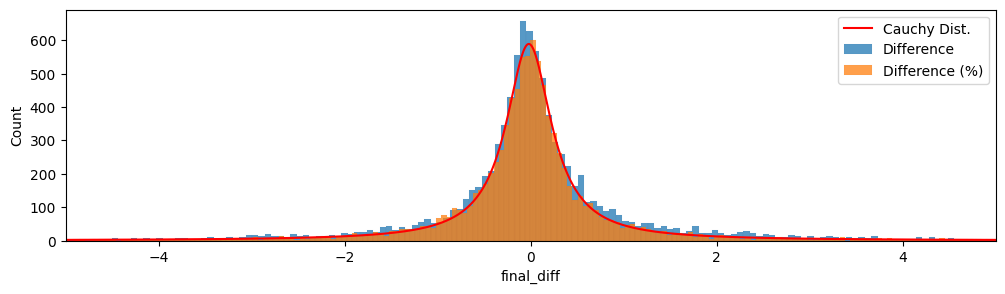

In [18]:
plt.figure(figsize=(12,3))
sns.histplot(agg_results_df['final_diff'], label='Difference')
sns.histplot(agg_results_df['final_diff_percent'], label='Difference (%)')
#plt.axvline(-0.358677)
#plt.axvline(-0.019532, color='gold')
#plt.axvline(0.370316)

x=np.linspace(-5,5,10000)

arg1, arg2 = stats.cauchy.fit(agg_results_df['final_diff_percent'])
y2 = stats.cauchy.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y2*550, color='red', label = 'Cauchy Dist.')
plt.legend()

plt.xlim(-5,5)

(-5.0, 5.0)

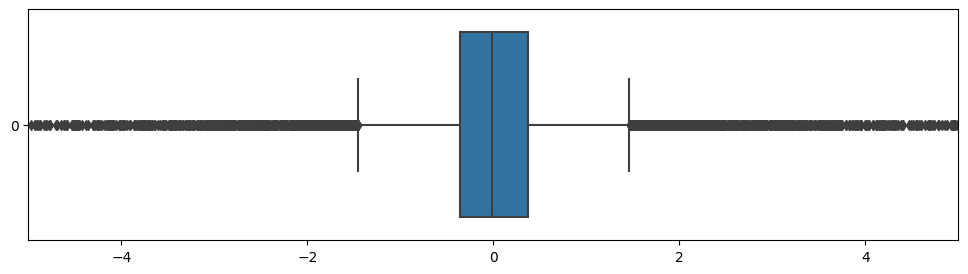

In [19]:
plt.figure(figsize=(12,3))
sns.boxplot(agg_results_df['final_diff'], orient='h')

plt.xlim(-5,5)

#### Area Difference

In [20]:
agg_results_df['area_diff'].describe()

count     9584.000000
mean         3.695439
std        420.526037
min     -11955.006088
25%        -54.305645
50%         -2.224089
75%         53.341998
max       9502.399189
Name: area_diff, dtype: float64

In [21]:
agg_results_df['area_diff_percent'].describe()

count    9584.000000
mean       -0.009790
std         0.548176
min       -19.275598
25%        -0.135873
50%        -0.006213
75%         0.117244
max         7.056540
Name: area_diff_percent, dtype: float64

(-1000.0, 1000.0)

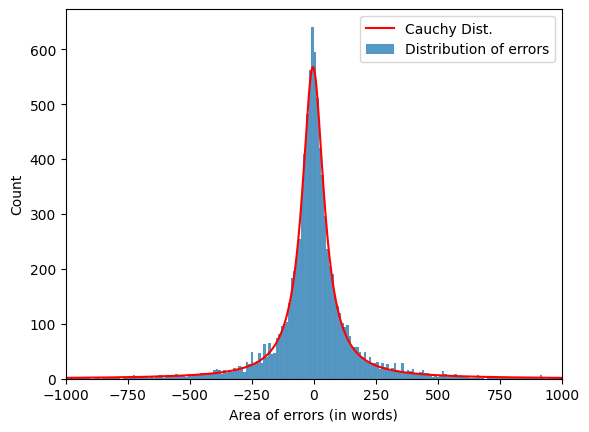

In [22]:
sns.histplot(agg_results_df['area_diff'], label='Distribution of errors')

x=np.linspace(-1000,1000,10000)

arg1, arg2 = stats.cauchy.fit(agg_results_df['area_diff'])
y2 = stats.cauchy.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y2*95000, color='red', label = 'Cauchy Dist.')
plt.legend()
plt.xlabel("Area of errors (in words)")
plt.xlim(-1000,1000)

#### Absolute Area Difference

In [23]:
agg_results_df['abs_area_diff'].describe()

count     9584.000000
mean       149.164806
std        395.117707
min          0.916534
25%         25.810128
50%         58.029852
75%        138.274557
max      11956.025614
Name: abs_area_diff, dtype: float64

<Axes: xlabel='abs_area_diff', ylabel='Count'>

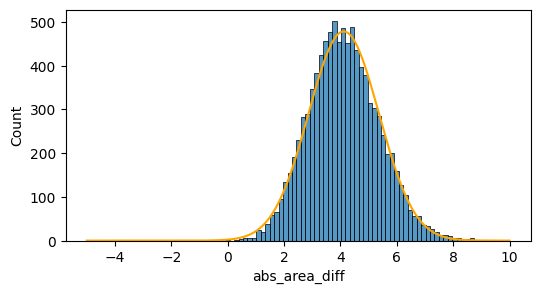

In [24]:
plt.figure(figsize=(6,3))
sns.histplot(np.log(agg_results_df['abs_area_diff']))

x=np.linspace(-5,10,10000)

arg1, arg2 = stats.norm.fit(np.log(agg_results_df['abs_area_diff']))
y1 = stats.norm.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y1*1500, color='orange')

#plt.xlim(0,1000)

(0.0, 1000.0)

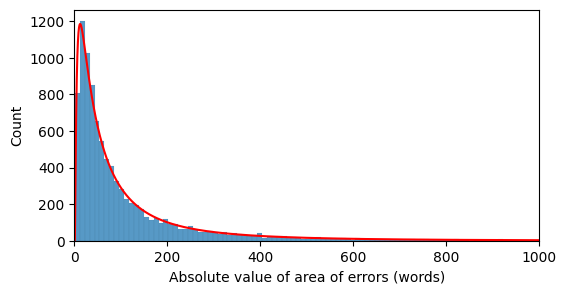

In [25]:
plt.figure(figsize=(6,3))
sns.histplot((agg_results_df['abs_area_diff']))

x=np.linspace(-5,1000,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['abs_area_diff']))
y1 = stats.lognorm.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*100000, color='red')

plt.xlabel("Absolute value of area of errors (words)")
plt.xlim(0,1000)

In [26]:
agg_results_df['abs_area_diff_percent'].describe()

count    9584.000000
mean        0.269799
std         0.479836
min         0.001283
25%         0.061753
50%         0.135454
75%         0.292623
max        19.275598
Name: abs_area_diff_percent, dtype: float64

<Axes: xlabel='abs_area_diff_percent', ylabel='Count'>

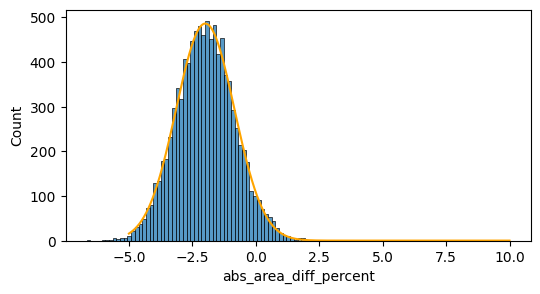

In [27]:
plt.figure(figsize=(6,3))
sns.histplot(np.log(agg_results_df['abs_area_diff_percent']))

x=np.linspace(-5,10,10000)

arg1, arg2 = stats.norm.fit(np.log(agg_results_df['abs_area_diff_percent']))
y1 = stats.norm.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y1*1400, color='orange')

#plt.xlim(0,1000)

(0.0, 3.0)

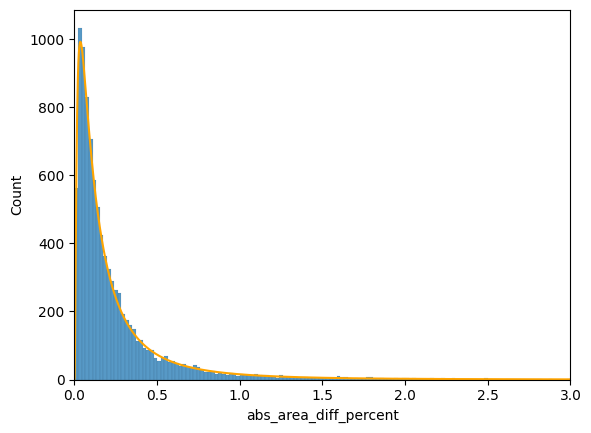

In [28]:
#plt.figure(figsize=(6,3))
sns.histplot((agg_results_df['abs_area_diff_percent']))

x=np.linspace(-5,10,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['abs_area_diff_percent']))
y1 = stats.lognorm.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*200, color='orange')

plt.xlim(0,3)

### RMSE

In [29]:
agg_results_df['rescaled_rmse_score'].describe()

count    9584.000000
mean        0.536465
std         1.594698
min         0.002887
25%         0.085083
50%         0.196342
75%         0.470264
max        52.028599
Name: rescaled_rmse_score, dtype: float64

<Axes: xlabel='rescaled_rmse_score', ylabel='Count'>

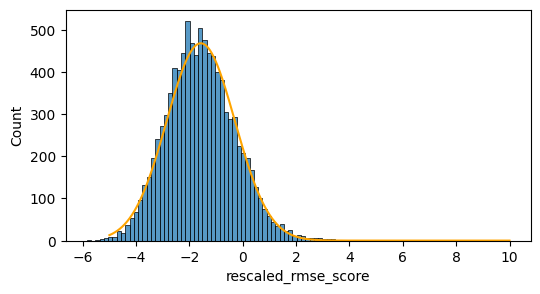

In [30]:
plt.figure(figsize=(6,3))
sns.histplot(np.log(agg_results_df['rescaled_rmse_score']))

x=np.linspace(-5,10,10000)

arg1, arg2 = stats.norm.fit(np.log(agg_results_df['rescaled_rmse_score']))
y1 = stats.norm.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y1*1500, color='orange')

#plt.xlim(0,1000)

(0.0, 3.0)

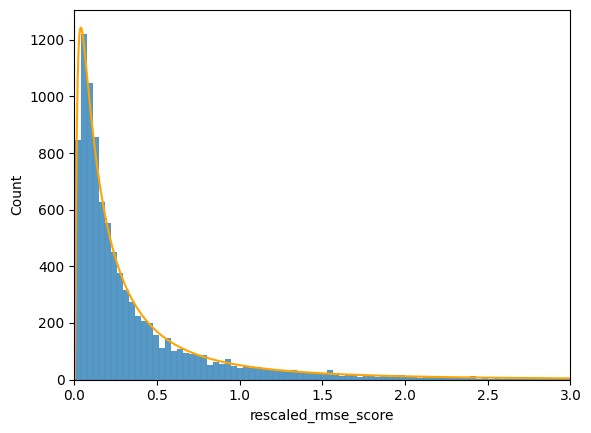

In [31]:
#plt.figure(figsize=(6,3))
sns.histplot((agg_results_df['rescaled_rmse_score']))

x=np.linspace(-5,10,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_rmse_score']))
y1 = stats.lognorm.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*350, color='orange')

plt.xlim(0,3)

### MAE

In [32]:
agg_results_df['rescaled_mae_score'].describe()

count    9584.000000
mean        0.380522
std         1.007953
min         0.002338
25%         0.065842
50%         0.148035
75%         0.352741
max        30.500065
Name: rescaled_mae_score, dtype: float64

<Axes: xlabel='rescaled_mae_score', ylabel='Count'>

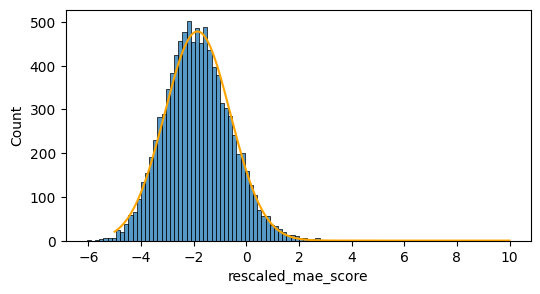

In [33]:
plt.figure(figsize=(6,3))
sns.histplot(np.log(agg_results_df['rescaled_mae_score']))

x=np.linspace(-5,10,10000)

arg1, arg2 = stats.norm.fit(np.log(agg_results_df['rescaled_mae_score']))
y1 = stats.norm.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y1*1500, color='orange')

#plt.xlim(0,1000)

(0.0, 3.0)

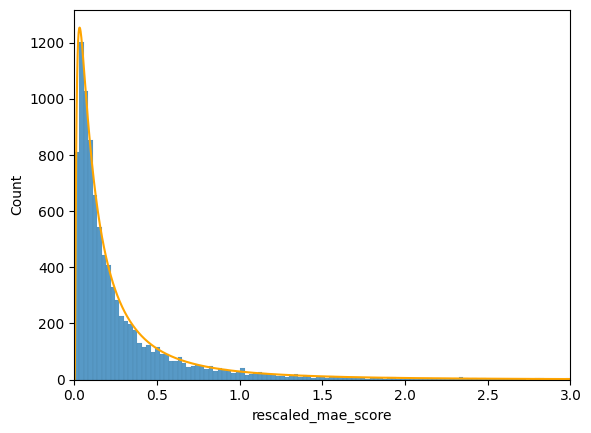

In [34]:
#plt.figure(figsize=(6,3))
sns.histplot((agg_results_df['rescaled_mae_score']))

x=np.linspace(-5,10,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_mae_score']))
y1 = stats.lognorm.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*270, color='orange')

plt.xlim(0,3)

### MAPE

In [35]:
agg_results_df['rescaled_mape_score'].describe()*100

count    958400.000000
mean         26.043717
std          46.692620
min           0.128722
25%           5.983707
50%          13.053859
75%          28.286572
max        1869.674273
Name: rescaled_mape_score, dtype: float64

<Axes: xlabel='rescaled_mape_score', ylabel='Count'>

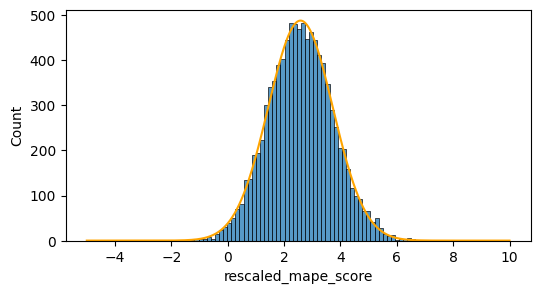

In [36]:
plt.figure(figsize=(6,3))
sns.histplot(np.log(agg_results_df['rescaled_mape_score']*100))

x=np.linspace(-5,10,10000)

arg1, arg2 = stats.norm.fit(np.log(agg_results_df['rescaled_mape_score']*100))
y1 = stats.norm.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y1*1400, color='orange')

#plt.xlim(0,1000)

(0.0, 300.0)

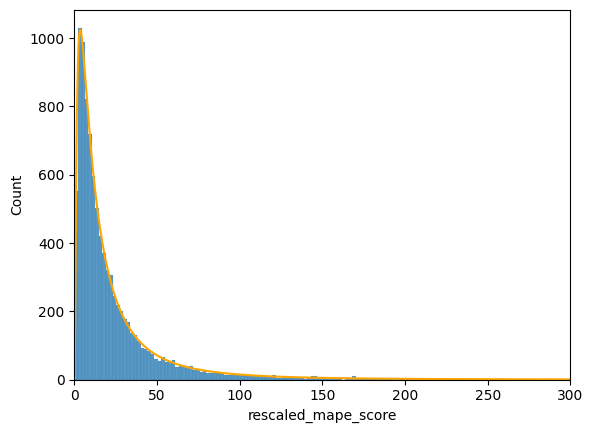

In [37]:
#plt.figure(figsize=(6,3))
sns.histplot((agg_results_df['rescaled_mape_score']*100))

x=np.linspace(-5,1000,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_mape_score']*100))
y1 = stats.lognorm.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*20000, color='orange')

plt.xlim(0,300)

#### Putting it together in one chart

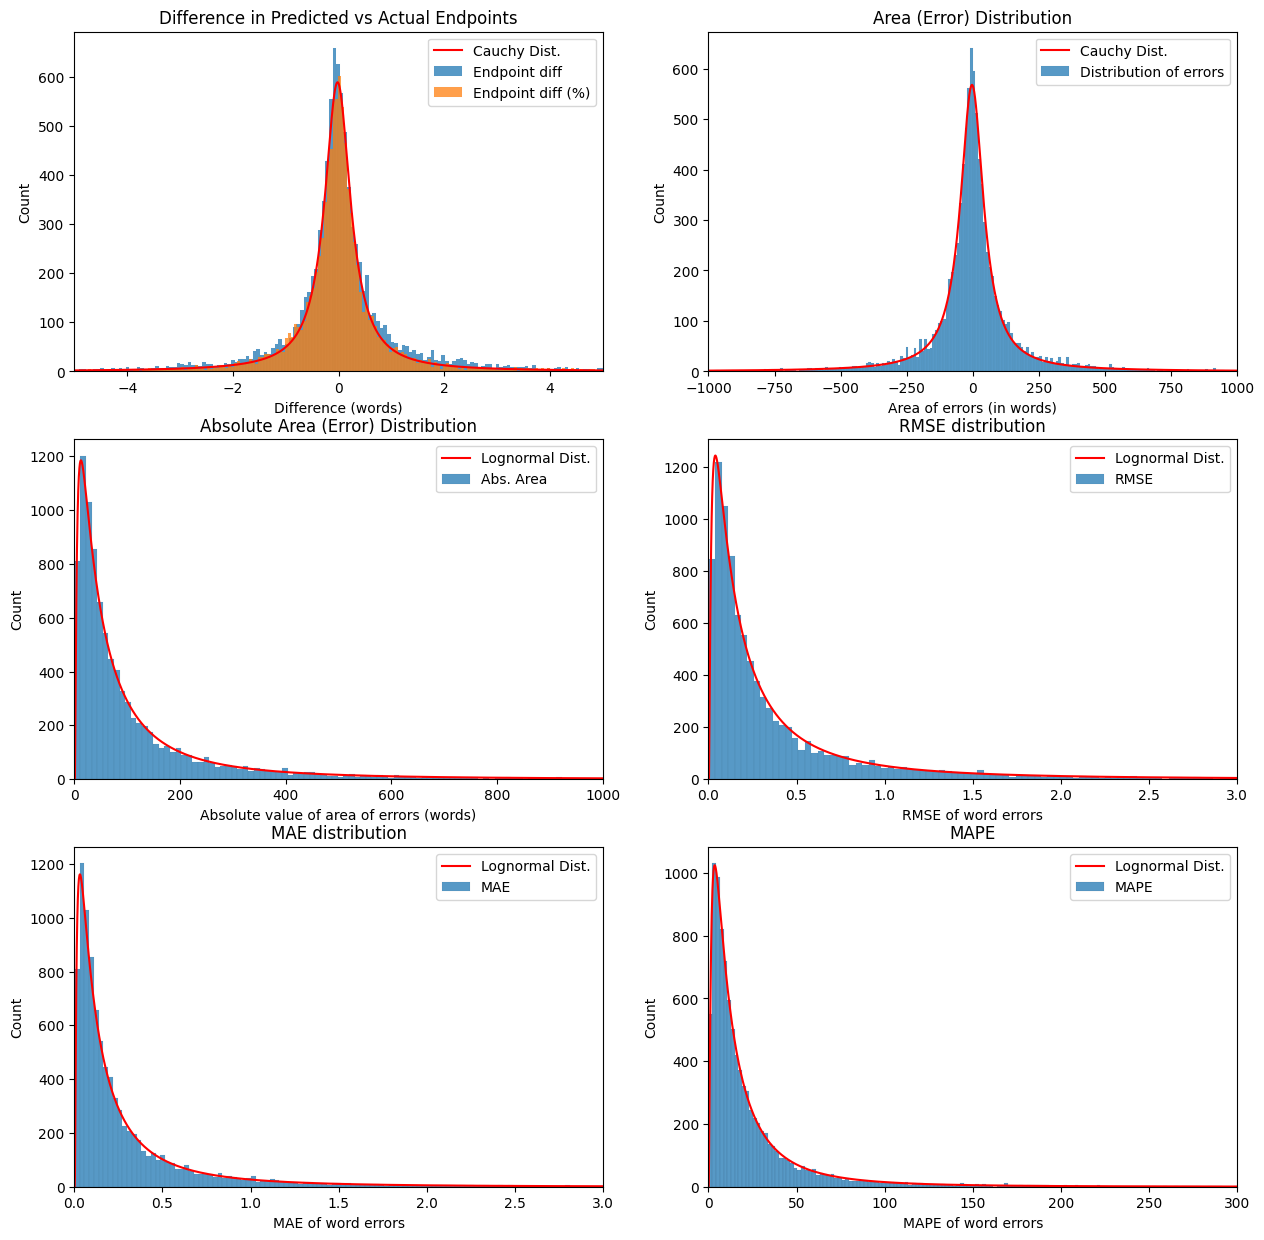

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

# FIGURE (0,0)
sns.histplot(agg_results_df['final_diff'], label='Endpoint diff', ax=axes[0,0])
sns.histplot(agg_results_df['final_diff_percent'], label='Endpoint diff (%)', ax=axes[0,0])

x00=np.linspace(-5,5,10000)
arg1, arg2 = stats.cauchy.fit(agg_results_df['final_diff_percent'])
y00 = stats.cauchy.pdf(x00,arg1,arg2)
sns.lineplot(x=x00,y=y00*550, color='red', label = 'Cauchy Dist.', ax=axes[0,0])

axes[0,0].legend()
axes[0,0].set_xlim(-5,5)
axes[0,0].set_title("Difference in Predicted vs Actual Endpoints")
axes[0,0].set_xlabel("Difference (words)")

# FIGURE (0,1)

sns.histplot(agg_results_df['area_diff'], label='Distribution of errors', ax=axes[0,1])

x01=np.linspace(-1000,1000,10000)
arg1, arg2 = stats.cauchy.fit(agg_results_df['area_diff'])
y01 = stats.cauchy.pdf(x01,arg1,arg2)
sns.lineplot(x=x01,y=y01*95000, color='red', label = 'Cauchy Dist.', ax=axes[0,1])

axes[0,1].legend()
axes[0,1].set_xlabel("Area of errors (in words)")
axes[0,1].set_title("Area (Error) Distribution")
axes[0,1].set_xlim(-1000,1000)

# FIGURE (1,0)

sns.histplot((agg_results_df['abs_area_diff']), label='Abs. Area', ax=axes[1,0])

x10=np.linspace(-5,1000,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['abs_area_diff']))
y10 = stats.lognorm.pdf(x10,arg1,arg2, arg3)
sns.lineplot(x=x10,y=y10*100000, color='red', label='Lognormal Dist.', ax=axes[1,0])

axes[1,0].set_xlabel("Absolute value of area of errors (words)")
axes[1,0].set_title("Absolute Area (Error) Distribution")
axes[1,0].legend()
axes[1,0].set_xlim(0,1000)

# FIGURE (1,1)

sns.histplot((agg_results_df['rescaled_rmse_score']), ax=axes[1,1], label="RMSE")

x11=np.linspace(-5,10,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_rmse_score']))
y11 = stats.lognorm.pdf(x11,arg1,arg2, arg3)
sns.lineplot(x=x11,y=y11*350, color='red', ax=axes[1,1], label="Lognormal Dist.")

axes[1,1].set_title("RMSE distribution")
axes[1,1].set_xlim(0,3)
axes[1,1].set_xlabel("RMSE of word errors")

# FIGURE (2,0)

sns.histplot((agg_results_df['rescaled_mae_score']), ax=axes[2,0], label="MAE")

x20=np.linspace(-5,10,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_mae_score']))
y20 = stats.lognorm.pdf(x20,arg1,arg2, arg3)
sns.lineplot(x=x20,y=y20*250, color='red', ax=axes[2,0], label='Lognormal Dist.')
axes[2,0].set_title("MAE distribution")
axes[2,0].set_xlim(0,3)
axes[2,0].legend()
axes[2,0].set_xlabel("MAE of word errors")

# FIGURE (2,1)

sns.histplot((agg_results_df['rescaled_mape_score']*100), ax=axes[2,1], label='MAPE')

x21=np.linspace(-5,1000,10000)

arg1, arg2, arg3 = stats.lognorm.fit((agg_results_df['rescaled_mape_score']*100))
y21 = stats.lognorm.pdf(x21,arg1,arg2, arg3)
sns.lineplot(x=x21,y=y21*20000, color='red', ax=axes[2,1], label='Lognormal Dist.')

axes[2,1].set_title("MAPE")
axes[2,1].set_xlim(0,300)
axes[2,1].set_xlabel("MAPE of word errors")
axes[2,1].legend()

fig.savefig("evaluation_metrics.png")

In [39]:
keep_cols = ['final_diff', 'area_diff', 'abs_area_diff', 
             'rescaled_rmse_score',	'rescaled_mae_score', 'rescaled_mape_score']

np.round(agg_results_df[keep_cols].describe()[1:].rename(columns={
    'final_diff' : "Endpoints", 
    'area_diff': "Area diff", 
    'abs_area_diff': "Absolute Area", 
    'rescaled_rmse_score': "RMSE score",	
    'rescaled_mae_score': "MAE score", 
    'rescaled_mape_score': "MAPE score"
}),4)

,Endpoints,Area diff,Absolute Area,RMSE score,MAE score,MAPE score
mean,0.0576,3.6954,149.1648,0.5365,0.3805,0.2604
std,4.9245,420.5260,395.1177,1.5947,1.0080,0.4669
min,-168.0672,-11955.0061,0.9165,0.0029,0.0023,0.0013
25%,-0.3587,-54.3056,25.8101,0.0851,0.0658,0.0598
50%,-0.0195,-2.2241,58.0299,0.1963,0.1480,0.1305
75%,0.3703,53.3420,138.2746,0.4703,0.3527,0.2829
max,129.0602,9502.3992,11956.0256,52.0286,30.5001,18.6967


In [40]:
agg_results_df.index[agg_results_df['original_tokens'] == 'llm'][0]

2919

In [41]:
agg_results_df.iloc[1919][keep_cols]

final_diff            -0.015342
area_diff              3.689986
abs_area_diff          5.244308
rescaled_rmse_score    0.015704
rescaled_mae_score     0.013378
rescaled_mape_score    0.038731
Name: 1919, dtype: object

In [42]:
def chart_maker(index_num):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    
    ################################
    #plot 1 - lineplot
    l1 = sns.lineplot(x = date_df['pub_date'][-392:].reset_index(drop=True), y = rescaled_actuals_df.iloc[:,index_num], 
                      ax=axes[0,0], label='Actual values')
    l2 = sns.lineplot(x = date_df['pub_date'][-392:].reset_index(drop=True), y = rescaled_preds_df.iloc[:,index_num], 
                      ax=axes[0,0], label='Predicted values')
    
    axes[0,0].fill_between(date_df['pub_date'][-392:].reset_index(drop=True), 
                           rescaled_actuals_df.iloc[:,index_num],rescaled_preds_df.iloc[:,index_num], color='lavenderblush',
                          label='Area difference')
    
    axes[0,0].set_ylabel('Daily Moving Average')
    axes[0,0].tick_params(rotation=30)
    axes[0,0].legend()
    axes[0,0].set_title('Error Drift Over Time')
    
    ################################
    #plot 2 - scatterplot
    sns.scatterplot(x=rescaled_actuals_df.iloc[:,index_num], 
                    y = rescaled_preds_df.iloc[:,index_num], ax=axes[0,1],
                    hue=rescaled_actuals_df.index, legend=False)
    
    axes[0,1].set_xlabel('Actual daily frequency')
    axes[0,1].set_ylabel("Predicted frequency")
    axes[0,1].set_xlim(min(rescaled_actuals_df.iloc[:,index_num].min(),rescaled_preds_df.iloc[:,index_num].min())*.99, 
                       max(rescaled_actuals_df.iloc[:,index_num].max(),rescaled_preds_df.iloc[:,index_num].max())*1.01)
    axes[0,1].set_ylim(min(rescaled_actuals_df.iloc[:,index_num].min(),rescaled_preds_df.iloc[:,index_num].min())*.95, 
                       max(rescaled_actuals_df.iloc[:,index_num].max(),rescaled_preds_df.iloc[:,index_num].max())*1.05)
    axes[0,1].set_title("Evolution of Error Space")
    
    ################################
    #plot 3 - area difference
    sns.lineplot(x = date_df['pub_date'][-392:].reset_index(drop=True), 
                y = rescaled_preds_df.iloc[:,index_num] - rescaled_actuals_df.iloc[:,index_num], color='crimson',
               ax=axes[1,0], linewidth=0.9)
    
    axes[1,0].fill_between(date_df['pub_date'][-392:].reset_index(drop=True), 
                           rescaled_preds_df.iloc[:,index_num] - rescaled_actuals_df.iloc[:,index_num], color='lavenderblush')
    axes[1,0].set_xticklabels('')
    axes[1,0].set_ylabel('Daily error')
    
    ################################
    #plot 4 - histogram
    sns.histplot(x = (rescaled_actuals_df.iloc[:,index_num] - rescaled_preds_df.iloc[:,index_num]), kde=True, bins=20,
                  ax=axes[1,1])
    axes[1,1].axvline(0,color='tab:red', linestyle='--')
    axes[1,1].set_xlabel("Distribution of errors")
    
    ################################
    plt.suptitle(f'Predictions and Errors for "{rescaled_actuals_df.columns[index_num]}"')
    
    plt.show();

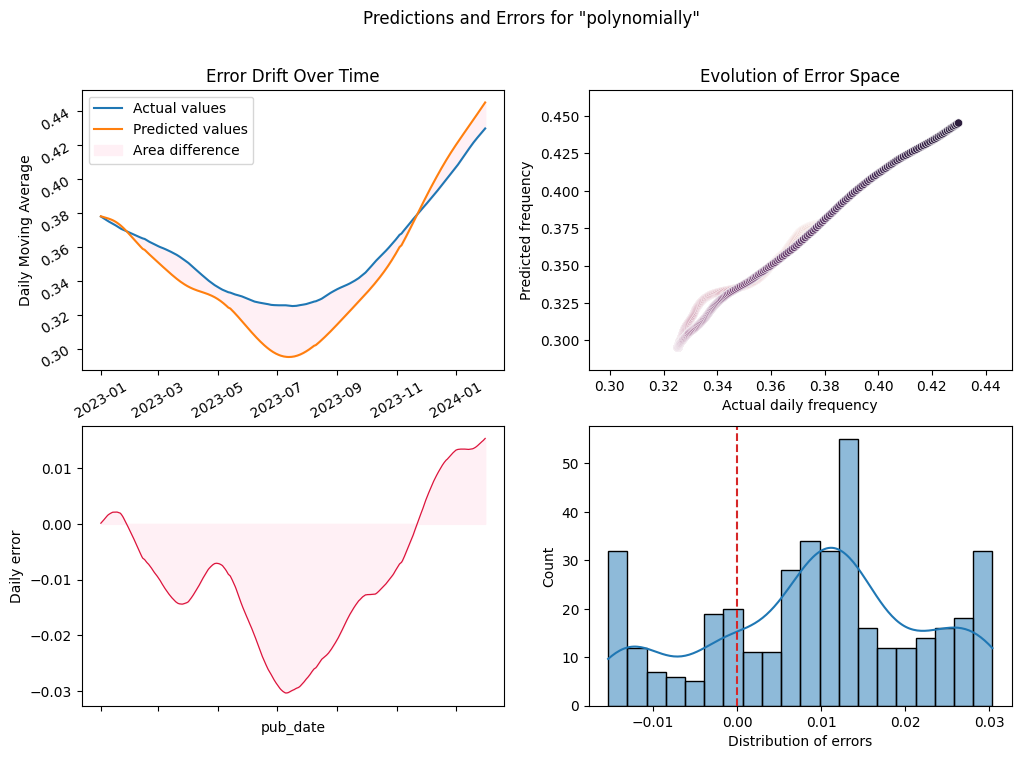

In [43]:
token_index = agg_results_df[agg_results_df['original_tokens']=='polynomially'].index[0]

chart_maker(token_index)

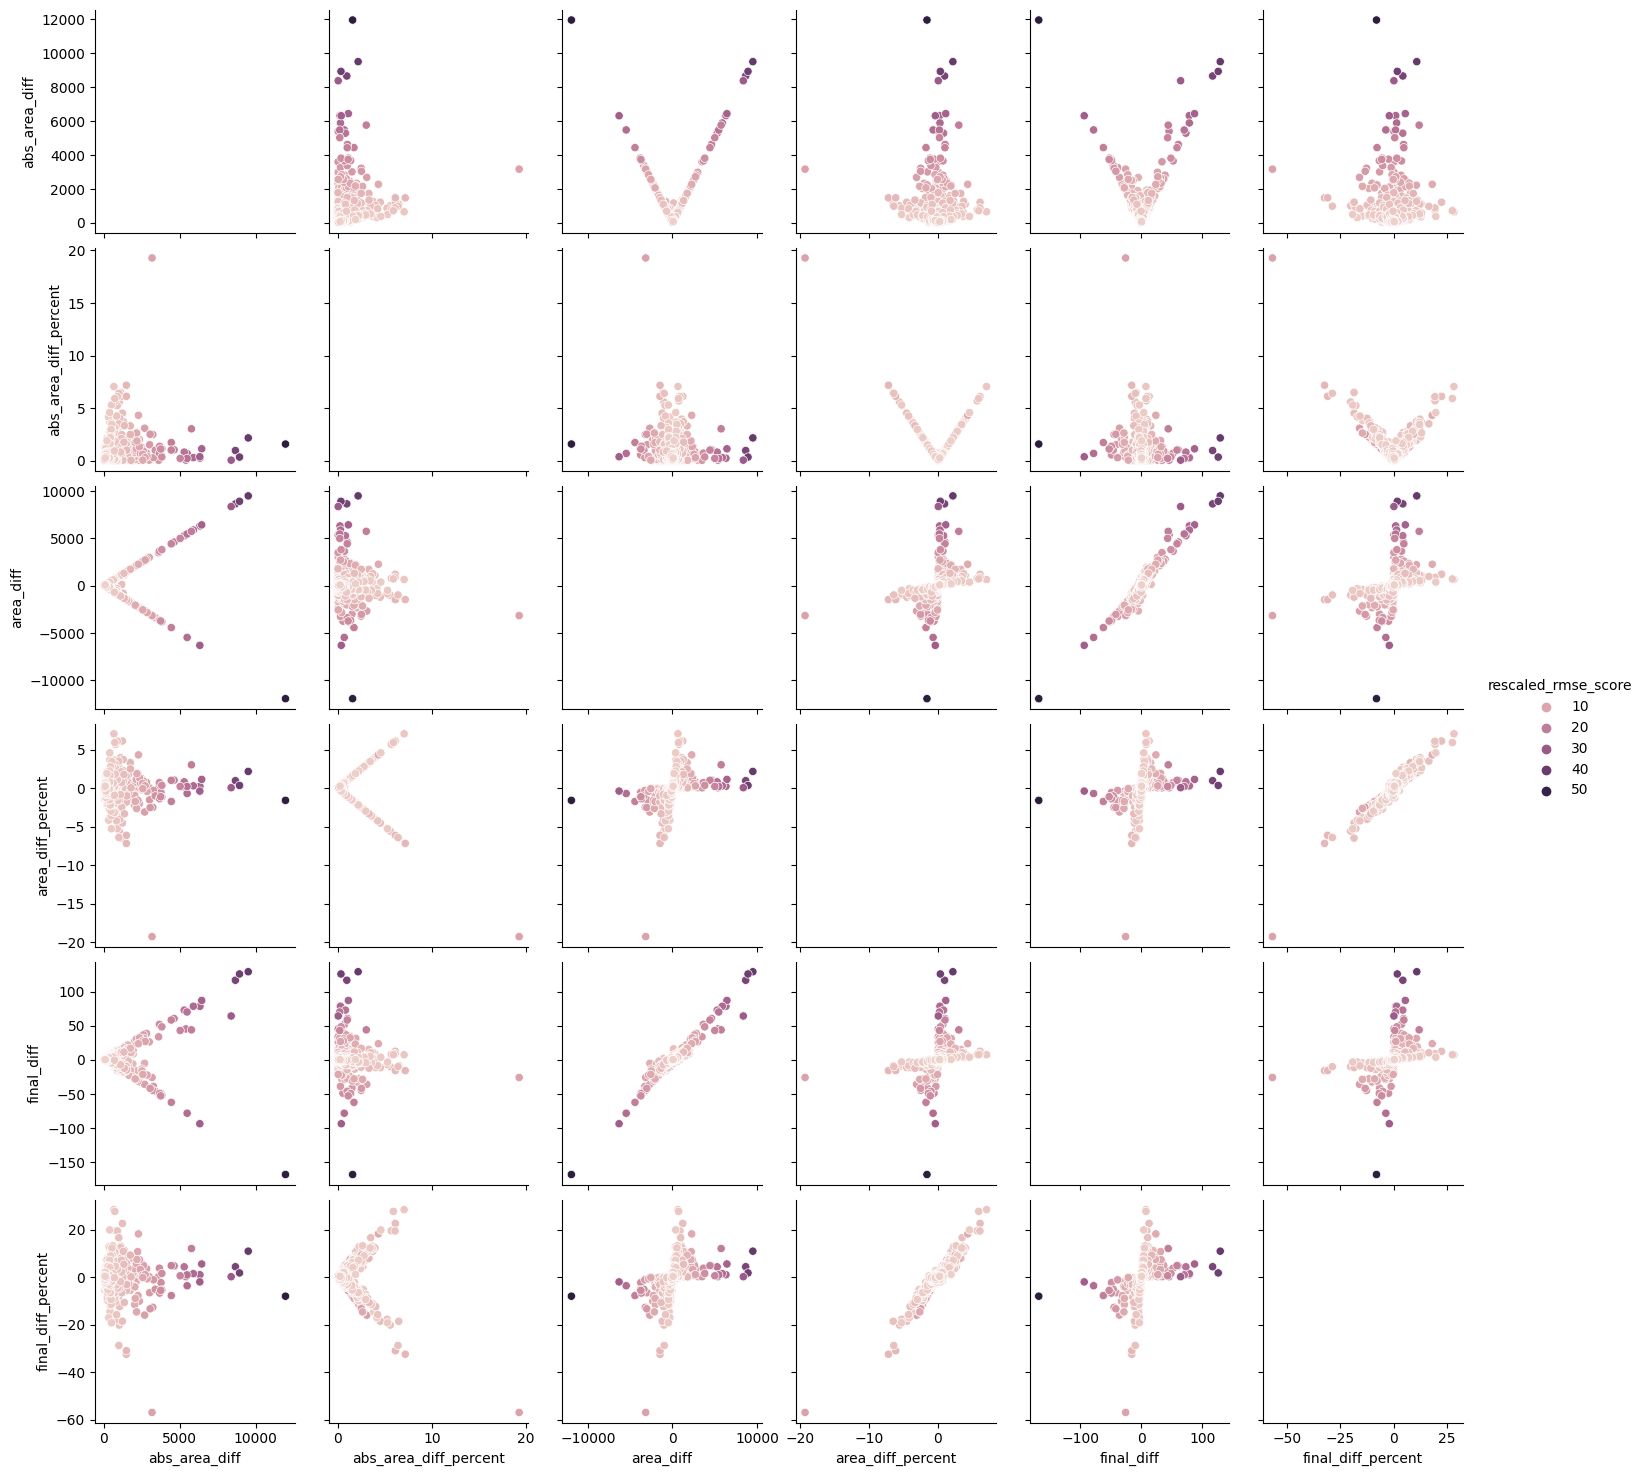

In [789]:
sns.pairplot(agg_results_df[['abs_area_diff','abs_area_diff_percent',
                             'area_diff','area_diff_percent',
                             'final_diff', 'final_diff_percent',
                            'rescaled_rmse_score']], hue='rescaled_rmse_score')

In [504]:
temp_dict = {}
for col in results_df.columns:
    temp_dict[col] = results_df[col].sum() / moving_avg_df.iloc[-392:][col].sum()

sum_results_df = pd.DataFrame([temp_dict]).T.reset_index().rename(columns={'index':'original_token',
                                                         0:'result_diff'})

sum_results_df.head()

,original_token,result_diff
0,algorithm,1.037583
1,give,1.017613
2,number,1.026120
3,complexity,1.036377
4,general,1.056401


In [505]:
cluster_dict = labels_df.set_index('original_tokens')['k_cluster'].to_dict()
sum_results_df['k_cluster'] = sum_results_df['original_token'].map(cluster_dict)

sum_results_df.groupby('k_cluster')['result_diff'].mean().sort_values(ascending=False)

k_cluster
33.0     1.231100
15.0     1.210540
24.0     1.126108
47.0     1.121435
0.0      1.097129
17.0     1.082158
18.0     1.076571
32.0     1.067464
143.0    1.059718
20.0     1.048893
9.0      1.048541
323.0    1.044291
14.0     1.044290
325.0    1.041669
38.0     1.040361
3.0      1.032186
35.0     1.032186
243.0    1.030236
39.0     1.027702
12.0     1.027106
110.0    1.022846
210.0    1.022819
1.0      1.021981
28.0     1.021269
122.0    1.019551
16.0     1.018174
2.0      1.017876
21.0     1.015968
6.0      1.014483
46.0     1.013132
29.0     1.008619
30.0     1.007345
5.0      1.007108
48.0     1.006989
45.0     1.006744
19.0     1.004167
44.0     1.002330
37.0     1.002245
40.0     1.002211
223.0    1.001923
8.0      0.998841
13.0     0.998616
11.0     0.995641
41.0     0.995450
42.0     0.986658
31.0     0.984548
49.0     0.984139
127.0    0.980972
36.0     0.980459
225.0    0.978580
123.0    0.969916
26.0     0.966479
7.0      0.957418
222.0    0.956501
343.0    0.952465


(-1.0, 250.0)

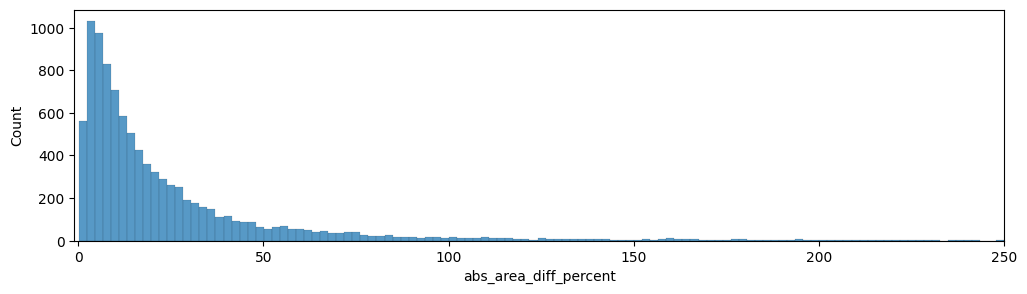

In [506]:
plt.figure(figsize=(12,3))
sns.histplot(agg_results_df['abs_area_diff_percent']*100)
plt.xlim(-1,250)

In [507]:
((sum_results_df['result_diff']-1)*100).describe()

count    9584.000000
mean        0.942003
std        52.303086
min      -667.769945
25%       -11.275894
50%         0.605540
75%        13.017432
max      1845.821071
Name: result_diff, dtype: float64

<Axes: xlabel='result_diff', ylabel='Count'>

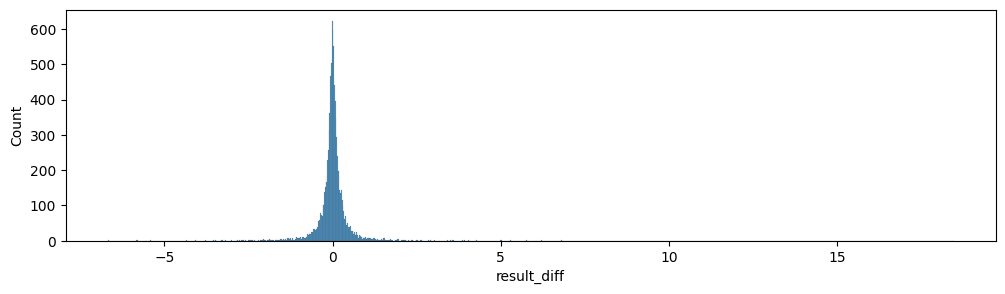

In [508]:
plt.figure(figsize=(12,3))
sns.histplot(sum_results_df['result_diff']-1)
#plt.xlim(-4,4)

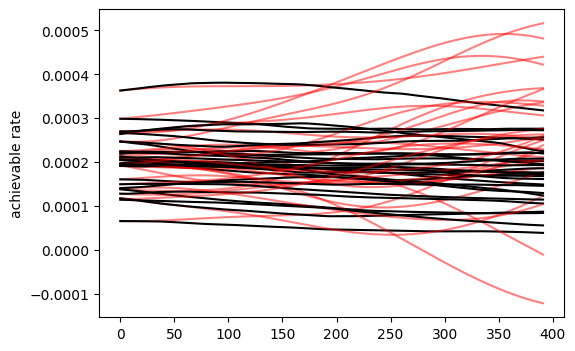

In [509]:
my_num = 15
plt.figure(figsize=(6,4))
for i in sum_results_df[sum_results_df['k_cluster']==my_num]['original_token']:
    sns.lineplot(results_df[i], color='red', alpha=0.5)
    sns.lineplot(moving_avg_df.iloc[-392:].reset_index()[i], color='black')

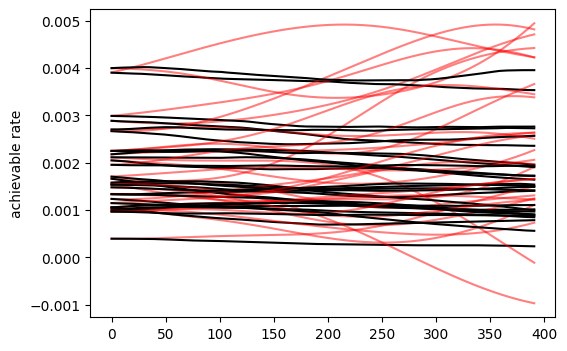

In [510]:
plt.figure(figsize=(6,4))
for i in sum_results_df[sum_results_df['k_cluster']==my_num]['original_token']:
    sns.lineplot(results_df[i]*date_df[i].max(), color='red', alpha=0.5)
    sns.lineplot(moving_avg_df.iloc[-392:].reset_index()[i]*date_df[i].max(), color='black')

In [511]:
sum_results_df.iloc[ sum_results_df['result_diff'].idxmax()]

original_token    bayesian network
result_diff              19.458211
k_cluster                     33.0
Name: 2840, dtype: object

<Axes: ylabel='language'>

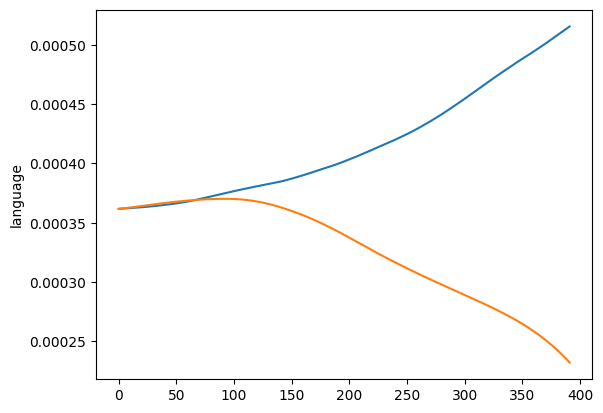

In [542]:
sns.lineplot(moving_avg_df.iloc[-392:].reset_index()['language'])
sns.lineplot(results_df['language'])
#sns.lineplot(results_df['bayesian network'])

In [513]:
results_df.shape

(392, 9584)

### Fitting curves

In [515]:
arg1, arg2, arg3 = stats.t.fit(sum_results_df['result_diff']-1)

(-1.0, 1.0)

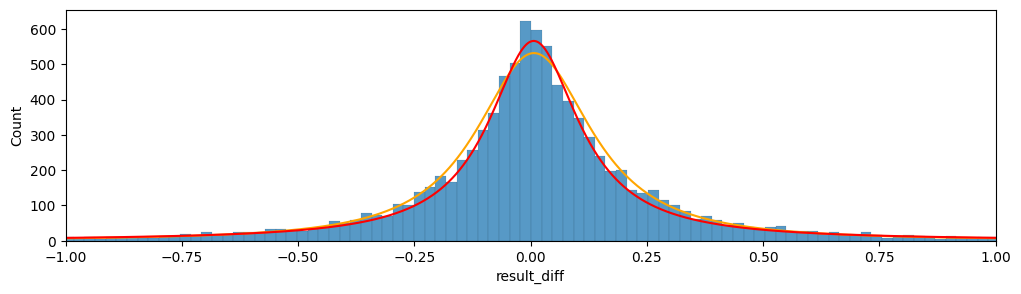

In [664]:
plt.figure(figsize=(12,3))

sns.histplot(sum_results_df['result_diff']-1)

x=np.linspace(-5,5,10000)

arg1, arg2, arg3 = stats.t.fit(sum_results_df['result_diff']-1)
y1 = stats.t.pdf(x,arg1,arg2, arg3)
sns.lineplot(x=x,y=y1*220, color='orange')

arg1, arg2 = stats.cauchy.fit(sum_results_df['result_diff']-1)
y2 = stats.cauchy.pdf(x,arg1,arg2)
sns.lineplot(x=x,y=y2*210, color='red')

plt.xlim(-1,1)

(-1.0, 1.0)

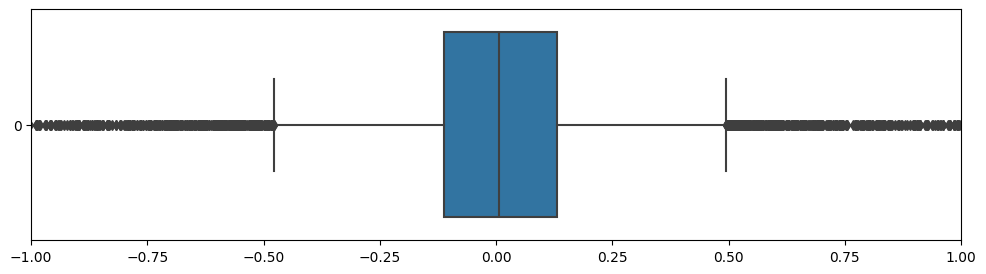

In [517]:
plt.figure(figsize=(12,3))

sns.boxplot(sum_results_df['result_diff']-1, orient='h')

plt.xlim(-1,1)

In [558]:
moving_avg_df

,ds,01,05,10,100,1000,10000,11,12,13,...,yield better,yielded,yielding,young,youtube,zero,zeroshot,zeroshot learning,zerosum,zone
0,2014-03-10,0.000345,0.000161,0.000478,0.000411,0.000236,0.000111,0.000297,0.000480,0.000355,...,0.000103,0.000120,0.000306,0.000172,0.000209,0.000730,0.000002,0.000008,0.000156,0.000252
1,2014-03-11,0.000345,0.000161,0.000478,0.000411,0.000236,0.000111,0.000297,0.000480,0.000356,...,0.000103,0.000120,0.000306,0.000172,0.000209,0.000730,0.000002,0.000008,0.000156,0.000252
2,2014-03-12,0.000345,0.000161,0.000478,0.000411,0.000236,0.000111,0.000297,0.000480,0.000356,...,0.000104,0.000120,0.000306,0.000172,0.000209,0.000730,0.000002,0.000008,0.000156,0.000252
3,2014-03-13,0.000345,0.000161,0.000479,0.000411,0.000236,0.000111,0.000298,0.000480,0.000357,...,0.000104,0.000120,0.000306,0.000172,0.000209,0.000731,0.000002,0.000008,0.000156,0.000252
4,2014-03-14,0.000345,0.000161,0.000479,0.000411,0.000236,0.000111,0.000298,0.000480,0.000358,...,0.000104,0.000120,0.000306,0.000172,0.000210,0.000731,0.000002,0.000009,0.000156,0.000252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3569,2024-01-27,0.000210,0.000253,0.000935,0.000632,0.000338,0.000233,0.000588,0.000737,0.000629,...,0.000225,0.000348,0.000595,0.000189,0.000218,0.000545,0.000410,0.000233,0.000176,0.000225
3570,2024-01-28,0.000210,0.000253,0.000935,0.000633,0.000338,0.000233,0.000588,0.000737,0.000630,...,0.000225,0.000349,0.000596,0.000189,0.000218,0.000545,0.000411,0.000234,0.000176,0.000225
3571,2024-01-29,0.000210,0.000253,0.000935,0.000633,0.000338,0.000233,0.000588,0.000737,0.000630,...,0.000225,0.000349,0.000597,0.000189,0.000218,0.000545,0.000412,0.000234,0.000176,0.000225
3572,2024-01-30,0.000209,0.000253,0.000935,0.000633,0.000338,0.000233,0.000588,0.000737,0.000630,...,0.000225,0.000349,0.000598,0.000189,0.000218,0.000545,0.000412,0.000234,0.000176,0.000224


105

<Axes: >

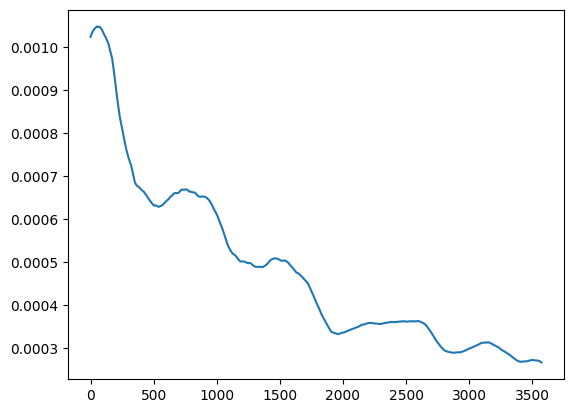

In [591]:
moving_avg_df['shortest path'].plot()